# Creating my personal visited continents video

## Imports

In [1]:
!pip uninstall shapely
!pip install shapely --no-binary shapely
!apt-get -qq install python-cartopy python3-cartopy
import cartopy.crs as ccrs
import cv2
import cartopy.io.shapereader as shpreader
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

Uninstalling Shapely-1.6.4:
  Would remove:
    /usr/lib/python3/dist-packages/Shapely-1.6.4.egg-info
    /usr/lib/python3/dist-packages/shapely
Proceed (y/n)? y
  Successfully uninstalled Shapely-1.6.4
     |████████████████████████████████| 389kB 10.0MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for shapely ... done


In [2]:
!pip install pycountry_convert
import pycountry_convert as pc

In [3]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name.upper()

def country_list_to_continent_set(country_list):
    return set(map(country_to_continent, country_list))

## Consts

In [4]:
CONTINENT_COLOR = np.array([(35, 139, 69)]) / 255.
DEFAULT_COLOR = np.zeros(3)

VISITED_COUNTRIES_BY_YEAR = {2019: ["Argentina", "Brazil", "Chile", "Bolivia", "Peru", "Ecuador", "Colombia"], 
                             2018: ["United Republic of Tanzania", "Czechia", "Bosnia and Herzegovina"],
                             2017: ["France", "Switzerland", "Germany", "Austria"],
                             2016: ["Jordan", "United States of America", "Germany", "Vietnam"],
                             2015: ["United States of America", "Kyrgyzstan"],
                             2014: ["Albania", "Montenegro"],
                             2013: ["Georgia"],
                             2012: ["Nepal"],
                             2010: ["South Korea", "New Zealand"],
                             2008: ["Spain"],
                             2004: ["Poland"],
                             2003: ["Russia"],
                             2002: ["Netherlands"],
                             2000: ["Italy"],
                             1990: ["Israel"],
                             1987: ["Russia"]}

In [5]:
continents_by_year = {y: country_list_to_continent_set(c) for y,c in VISITED_COUNTRIES_BY_YEAR.items()}
continents_by_year

{1987: {'EUROPE'},
 1990: {'ASIA'},
 2000: {'EUROPE'},
 2002: {'EUROPE'},
 2003: {'EUROPE'},
 2004: {'EUROPE'},
 2008: {'EUROPE'},
 2010: {'ASIA', 'OCEANIA'},
 2012: {'ASIA'},
 2013: {'ASIA'},
 2014: {'EUROPE'},
 2015: {'ASIA', 'NORTH AMERICA'},
 2016: {'ASIA', 'EUROPE', 'NORTH AMERICA'},
 2017: {'EUROPE'},
 2018: {'AFRICA', 'EUROPE'},
 2019: {'SOUTH AMERICA'}}

In [6]:
continents_by_year[2019].add('ANTARCTICA')

## Read continents data
(from [NaturalEarthData](https://www.naturalearthdata.com/) website)

In [7]:
shapename = 'geography_regions_polys'
areas_shp = shpreader.natural_earth(resolution='110m', name=shapename)

In [8]:
def process_all_continents(ax):
    """
    Draw all continents in default color and create a map of continent names
    """
    continent_name_to_record = {}
    for area in shpreader.Reader(areas_shp).records():
        area_type = area.attributes['featurecla']
        if area_type == 'Continent':
            continent_name = area.attributes['name'].upper()
            continent_name_to_record[continent_name] = area
            ax.add_geometries(area.geometry, ccrs.PlateCarree(),
                              facecolor=DEFAULT_COLOR, label=continent_name)
    return continent_name_to_record

In [9]:
def color_visited(continent_name_to_record, ax):
  """
  Generate figure for every year with the continents visited so far
  """
  img_files = []
  sorted_years = sorted(continents_by_year.keys())
  visited_set = set()
  for year in range(sorted_years[0], sorted_years[-1]+1):
    if year in continents_by_year:
      visited = continents_by_year[year]
    else:
      visited = None
    if visited is not None:
      for continent_name, continent in continent_name_to_record.items():
        if continent_name in visited:
          ax.add_geometries(continent.geometry, ccrs.PlateCarree(),
                       facecolor=CONTINENT_COLOR,
                       label=continent_name)
          visited_set.add(continent_name)

    # add text
    year_itm = ax.text(0.15, 0.2, year, fontsize=15, color = "red", 
        ha='center', va='center', transform=ax.transAxes)
    count_itm = ax.text(0.9, 0.2, len(visited_set), fontsize=15, color = "red", 
        ha='center', va='center', transform=ax.transAxes)
    
    img_file = "{}.png".format(year)
    plt.savefig(img_file, bbox_inches='tight', pad_inches=0)
    img_files.append(img_file)

    # prevent writing text over the next instances
    year_itm.set_visible(False)
    count_itm.set_visible(False)

  return img_files

In [10]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

continent_name_to_record = process_all_continents(ax)
img_files = color_visited(continent_name_to_record, ax)

plt.close()

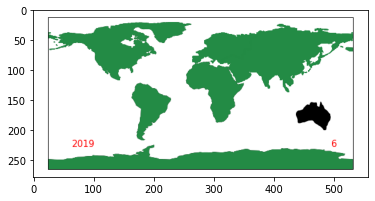

In [11]:
# see last image
img = mpimg.imread(img_files[-1])
plt.imshow(img);

## Generate video

In [12]:
img_array = []
for filename in img_files:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out_video = "where_was_i_continents.mp4" 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(out_video,fourcc,1,(width,height)) 
for i in range(len(img_array)):
    out.write(img_array[i])

# write last image 3 times to let it linger
out.write(img_array[i])
out.write(img_array[i])

out.release()

In [13]:
from google.colab import files
files.download(out_video) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>